In [173]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from datetime import datetime
from sqlalchemy import create_engine

In [2]:
url_template = 'https://tenki.jp/past/{}/{:02d}/{:02d}/amedas/3/17/'

In [3]:
def get_weather_for_one_day(year, month, day):
    url = url_template.format(year, month, day)
    html_doc = requests.get(url).text
    soup = BeautifulSoup(html_doc)
    table = soup.find(lambda tag: tag.name == 'table' and 'amedas-point-detail-entries-table' in tag['class'])

    try:
        df = pd.read_html(str(table), na_values=['---'], header=0)[0]
    except:
        raise ValueError('No data is available for {}/{:02d}/{:02d}'.format(year, month, day))
    df.drop(df.shape[0] - 1, inplace=True)
    df.columns = ['city', 'max_temp', 'min_temp', 'rain', 'wind', 'daylight']
    df['date'] = pd.to_datetime('{}/{}/{}'.format(year, month, day))
    
    return df

In [4]:
def get_weather_for_one_month(year, month, num_days=-1):
    days_of_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if num_days == -1:
        if year % 4 == 0 and month == 2:
            num_days = 29
        else:
            num_days = days_of_month[month - 1]
    
    df_month = []
    for day in range(1, num_days + 1):
        try:
            df_day = get_weather_for_one_day(year, month, day)
        except ValueError as e:
            print(e)
            continue
        df_month.append(df_day)
    
    return pd.concat(df_month)

In [5]:
def get_weather_from_2015():
    now = datetime.now()
    current_year, current_month, current_day = now.year, now.month, now.day
    
    df = []
    for year in range(2015, current_year + 1):
        for month in range(1, 13):
            if year == current_year and month > current_month:
                break
            elif year == current_year and month == current_month:
                df_month = get_weather_for_one_month(year, month, current_day - 1)
            else:
                df_month = get_weather_for_one_month(year, month)
            df.append(df_month)
    
    return pd.concat(df)

In [193]:
df = get_weather_from_2015()

In [194]:
df.head(10)

,city,max_temp,min_temp,rain,wind,daylight,date
0,横浜,8.5 (00:50),0.6 (22:30),0.0,8.8 (01:10),0.1,2015-01-01
1,日吉,NaN,NaN,0.0,NaN,NaN,2015-01-01
2,海老名,7.2 (10:10),-4.3 (23:40),0.5,5.3 (12:50),3.2,2015-01-01
3,三浦,10.2 (00:10),-0.5 (22:20),0.5,7.3 (14:00),1.2,2015-01-01
4,辻堂,8.3 (00:10),-1.2 (23:00),0.0,6.4 (14:10),1.1,2015-01-01
5,相模原中央,NaN,NaN,0.0,NaN,NaN,2015-01-01
6,平塚,NaN,NaN,1.0,NaN,NaN,2015-01-01
7,相模湖,NaN,NaN,0.5,NaN,NaN,2015-01-01
8,丹沢湖,NaN,NaN,2.5,NaN,NaN,2015-01-01
9,小田原,8.2 (12:30),-3.7 (23:50),3.0,8.2 (12:50),5.3,2015-01-01


In [203]:
df.tail()

,city,max_temp,min_temp,rain,wind,daylight,date
6,平塚,NaN,NaN,0.0,NaN,NaN,2019-08-05
7,相模湖,NaN,NaN,0.0,NaN,NaN,2019-08-05
8,丹沢湖,NaN,NaN,0.0,NaN,NaN,2019-08-05
9,小田原,32.7 (13:30),23.4 (04:40),0.0,4.3 (16:40),12.1,2019-08-05
10,箱根,NaN,NaN,0.0,NaN,NaN,2019-08-05


In [196]:
def clean_data(df, city_mapping):
    df = df.copy()
    df.city = df.city.map(city_mapping)
    temp = df.max_temp.str.split()
    df.max_temp = pd.to_numeric(temp.str.get(0))
    temp = df.min_temp.str.split()
    df.min_temp = pd.to_numeric(temp.str.get(0))
    temp = df.wind.str.split()
    df.wind = pd.to_numeric(temp.str.get(0))
    df.rain = pd.to_numeric(df.rain)
    
    df.reset_index()
    
    return df

In [197]:
city_mapping = {
    '横浜': 'Yokohama',
    '日吉': 'Hiyoshi',
    '海老名': 'Ebina',
    '三浦': 'Miura',
    '辻堂': 'Tsujido',
    '相模原中央': 'Sagamihara-Chuo',
    '平塚': 'Hiratsuka',
    '相模湖': 'Sagamiko',
    '丹沢湖': 'Tanzawako',
    '小田原': 'Odawara',
    '箱根': 'Hakone'
}

In [201]:
cleaned_df = clean_data(df, city_mapping)

In [202]:
cleaned_df.head(10)

,city,max_temp,min_temp,rain,wind,daylight,date
0,Yokohama,8.5,0.6,0.0,8.8,0.1,2015-01-01
1,Hiyoshi,NaN,NaN,0.0,NaN,NaN,2015-01-01
2,Ebina,7.2,-4.3,0.5,5.3,3.2,2015-01-01
3,Miura,10.2,-0.5,0.5,7.3,1.2,2015-01-01
4,Tsujido,8.3,-1.2,0.0,6.4,1.1,2015-01-01
5,Sagamihara-Chuo,NaN,NaN,0.0,NaN,NaN,2015-01-01
6,Hiratsuka,NaN,NaN,1.0,NaN,NaN,2015-01-01
7,Sagamiko,NaN,NaN,0.5,NaN,NaN,2015-01-01
8,Tanzawako,NaN,NaN,2.5,NaN,NaN,2015-01-01
9,Odawara,8.2,-3.7,3.0,8.2,5.3,2015-01-01


In [204]:
cleaned_df.to_csv('kanagawa_weather_20150101_20190804.csv', index=False)

In [219]:
engine = create_engine('sqlite:///weather.sqlite')

In [220]:
cleaned_df.to_sql('weather_details', con=engine, index=False)

In [223]:
df_yoko = pd.read_sql("SELECT * FROM weather_details WHERE city = 'Yokohama'", con=engine, parse_dates='date')

In [224]:
df_yoko = df_yoko.set_index('date')

In [226]:
df_yoko.head()

,city,max_temp,min_temp,rain,wind,daylight
date,,,,,,
2015-01-01,Yokohama,8.5,0.6,0.0,8.8,0.1
2015-01-02,Yokohama,7.7,-0.8,0.0,4.9,5.9
2015-01-03,Yokohama,8.1,0.4,0.0,6.1,9.6
2015-01-04,Yokohama,9.3,1.0,0.0,3.0,6.7
2015-01-05,Yokohama,13.2,3.0,0.0,6.3,9.3


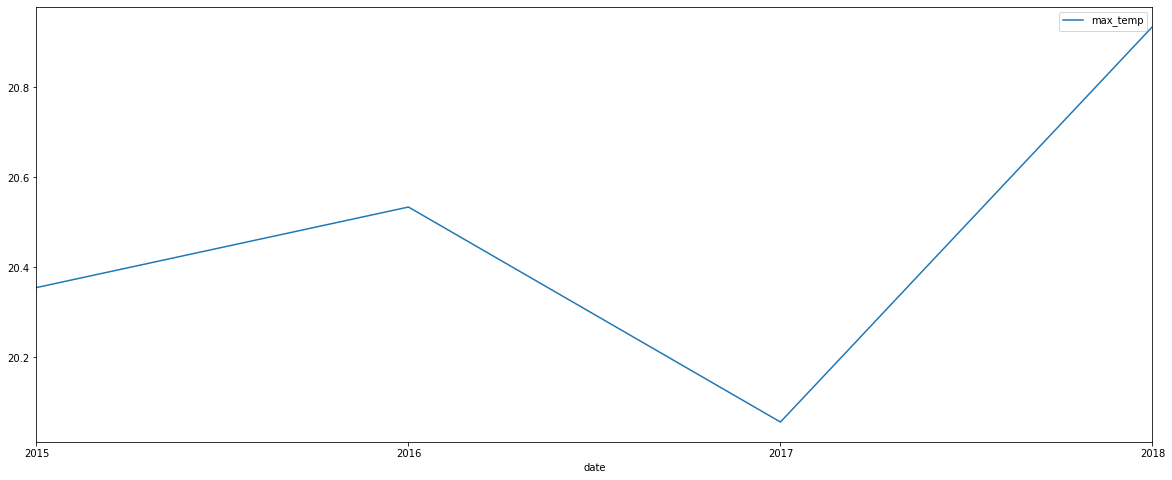

In [242]:
df_yoko[:'2018'].resample('Y').mean().plot(y='max_temp', figsize=(20, 8))

In [249]:
month_average = df_yoko['2015':'2019'].resample('M').mean()
# smoothed_temp = unsmoothed_temp.rolling(window=90).mean()

# compare_df = pd.DataFrame({'smoothed': smoothed_temp, 'unsmoothed': unsmoothed_temp})

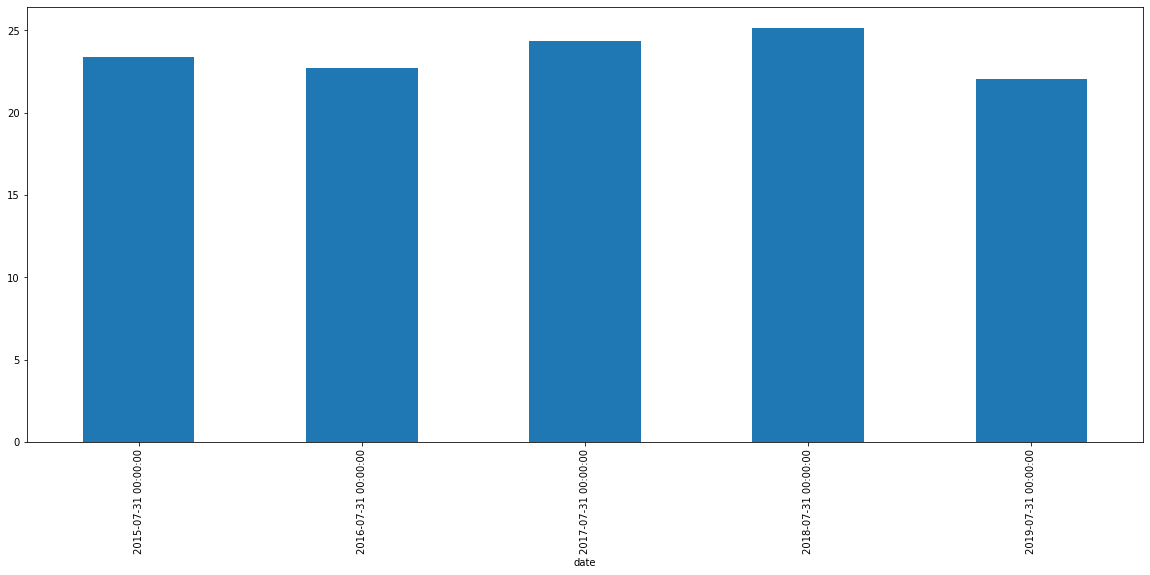

In [252]:
month_average[month_average.index.month == 7]['min_temp'].plot(kind='bar', figsize=(20, 8))

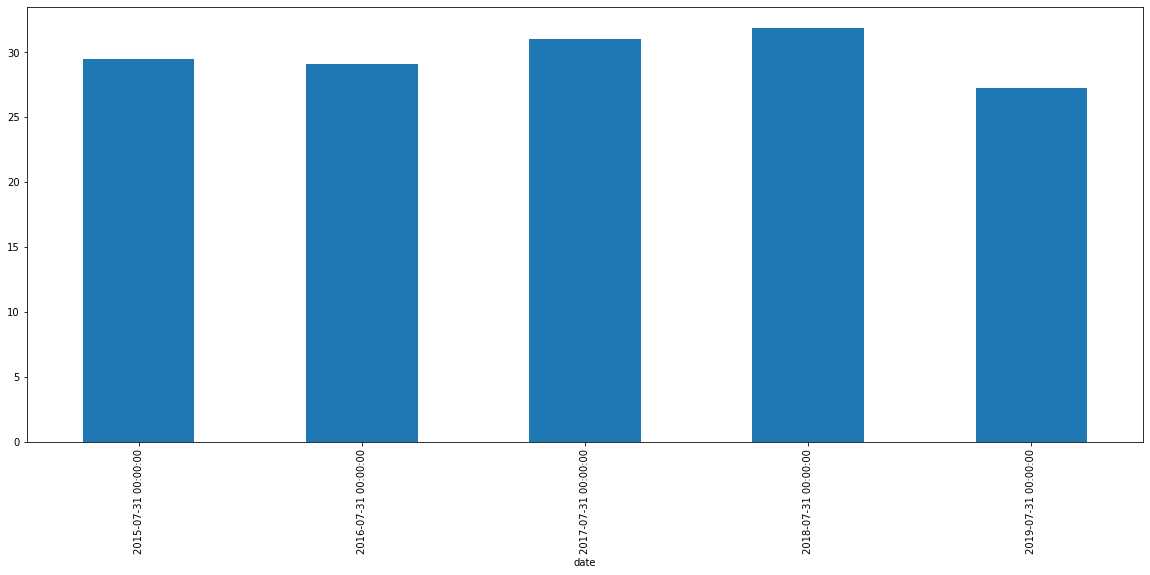

In [253]:
month_average[month_average.index.month == 7]['max_temp'].plot(kind='bar', figsize=(20, 8))

In [231]:
df_yoko_july = df_yoko[df_yoko.index.month == 7]
df_yoko_july.head(10)

,city,max_temp,min_temp,rain,wind,daylight
date,,,,,,
2015-07-01,Yokohama,26.4,19.2,17.0,10.2,0.0
2015-07-02,Yokohama,24.4,21.5,7.0,5.4,1.3
2015-07-03,Yokohama,24.4,20.5,103.0,6.4,0.1
2015-07-04,Yokohama,25.3,21.0,5.0,5.4,0.1
2015-07-05,Yokohama,21.5,19.1,21.5,3.0,0.0
2015-07-06,Yokohama,20.4,19.5,34.0,3.6,0.0
2015-07-07,Yokohama,23.4,19.5,2.5,3.2,0.0
2015-07-08,Yokohama,25.1,20.0,41.5,3.7,0.0
2015-07-09,Yokohama,20.8,19.2,22.5,4.4,0.0


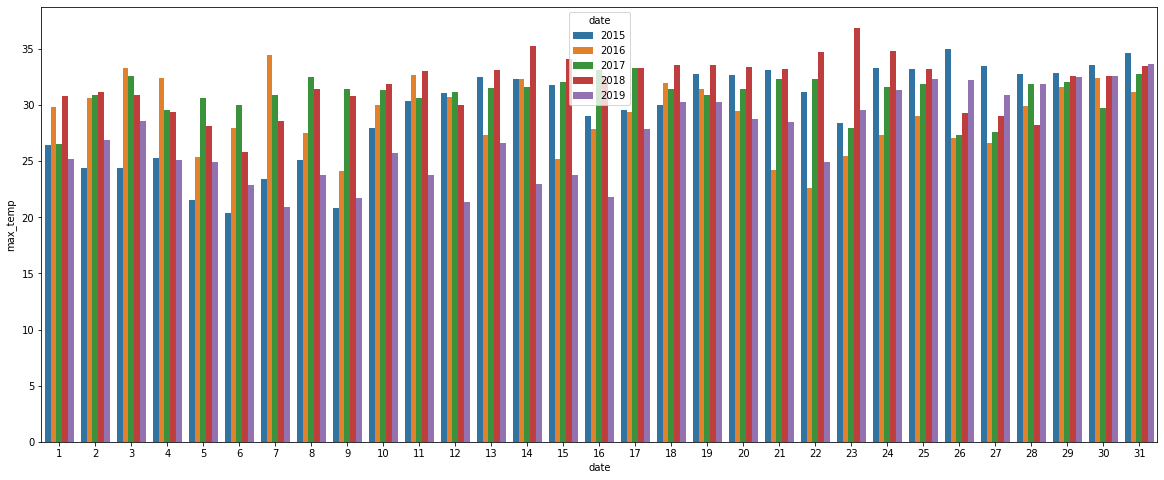

In [232]:
_ = plt.figure(figsize=(20, 8))
sns.barplot(x=df_yoko_july.index.day, y='max_temp', hue=df_yoko_july.index.year, data=df_yoko_july)

In [234]:
idx = df_yoko_july.groupby(df_yoko_july.index.day)['min_temp'].idxmin()
min_temp_july = df_yoko_july.loc[idx]
min_temp_july['min_temp']

date
2015-07-01    19.2
2015-07-02    21.5
2015-07-03    20.5
2015-07-04    21.0
2015-07-05    19.1
2015-07-06    19.5
2019-07-07    18.1
2019-07-08    18.2
2019-07-09    19.1
2015-07-10    18.6
2019-07-11    17.8
2019-07-12    17.9
2019-07-13    20.9
2019-07-14    20.4
2019-07-15    19.9
2019-07-16    19.3
2019-07-17    20.6
2019-07-18    22.4
2017-07-19    23.4
2016-07-20    24.0
2016-07-21    21.2
2016-07-22    20.9
2016-07-23    20.5
2016-07-24    20.8
2016-07-25    22.2
2016-07-26    21.8
2017-07-27    22.4
2018-07-28    20.3
2016-07-29    23.4
2016-07-30    23.4
2017-07-31    24.7
Name: min_temp, dtype: float64

In [235]:
min_temp_july.index.year.value_counts()

2019    11
2016     9
2015     7
2017     3
2018     1
Name: date, dtype: int64

In [236]:
idx = df_yoko_july.groupby(df_yoko_july.index.day)['max_temp'].idxmax()
max_temp_july = df_yoko_july.loc[idx]
max_temp_july['max_temp']

date
2018-07-01    30.8
2018-07-02    31.2
2016-07-03    33.3
2016-07-04    32.4
2017-07-05    30.6
2017-07-06    30.0
2016-07-07    34.5
2017-07-08    32.5
2017-07-09    31.4
2018-07-10    31.9
2018-07-11    33.0
2017-07-12    31.2
2018-07-13    33.1
2018-07-14    35.3
2018-07-15    34.1
2017-07-16    33.1
2017-07-17    33.3
2018-07-18    33.6
2018-07-19    33.6
2018-07-20    33.4
2018-07-21    33.2
2018-07-22    34.7
2018-07-23    36.9
2018-07-24    34.8
2015-07-25    33.2
2015-07-26    35.0
2015-07-27    33.5
2015-07-28    32.8
2015-07-29    32.9
2015-07-30    33.6
2015-07-31    34.6
Name: max_temp, dtype: float64

In [237]:
max_temp_july.index.year.value_counts()

2018    14
2015     7
2017     7
2016     3
Name: date, dtype: int64

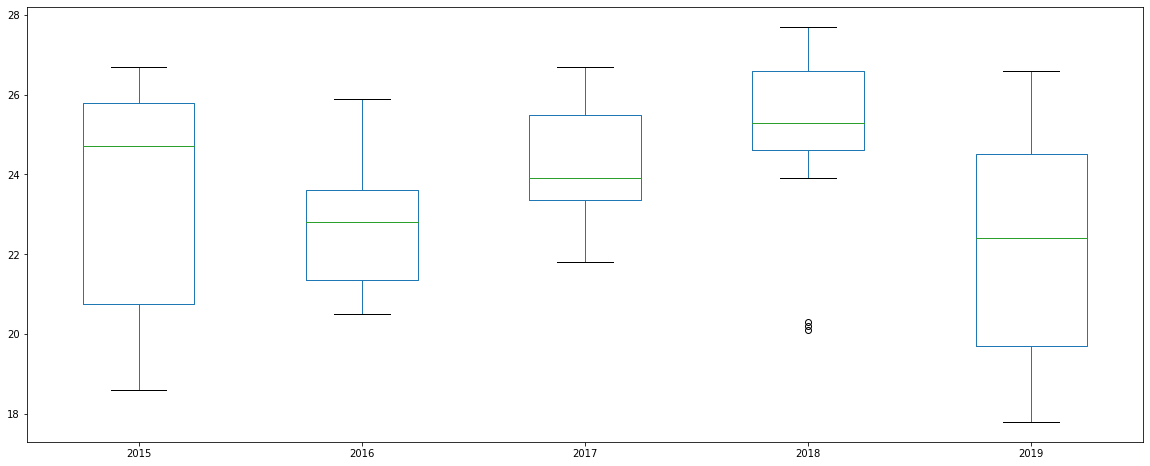

In [238]:
df_yoko_july.pivot_table(values='min_temp', columns=df_yoko_july.index.year, index=df_yoko_july.index.day).plot(kind='box', figsize=(20, 8))

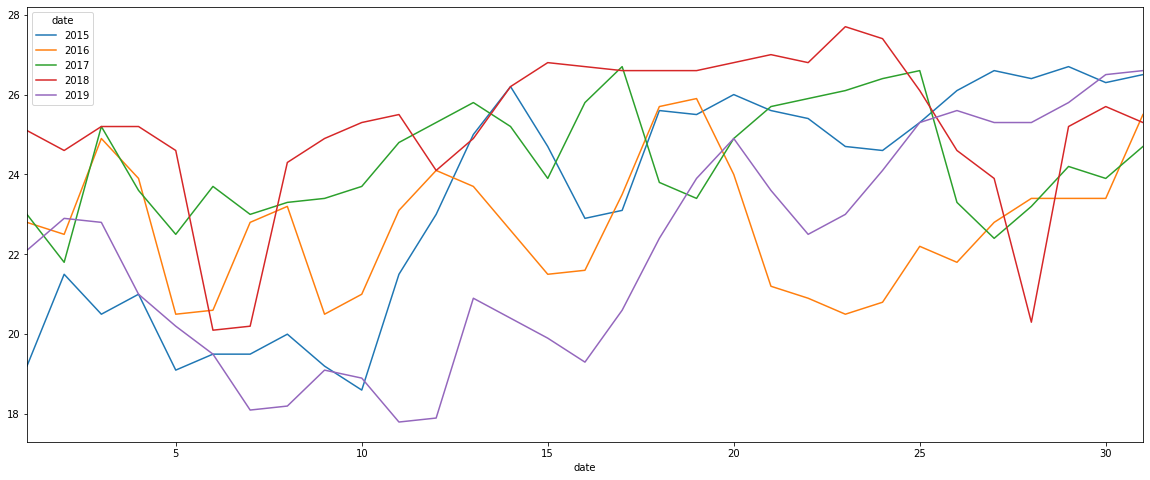

In [240]:
df_yoko_july.pivot_table(values='min_temp', columns=df_yoko_july.index.year, index=df_yoko_july.index.day).plot( figsize=(20, 8))